In [2]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import List, Dict
import numpy as np
import cv2
import torch
from torch import nn
from torchvision.transforms import Compose, Normalize, ToTensor
import timm
import os
import time
from PIL import Image
import torch.optim as optim

# 공식 깃헙에서 가져옴
def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [4]:
class EffNet(nn.Module):
    def __init__(self, backbone, n_out, is_sigmoid):
        super(EffNet, self).__init__()
        self.model = timm.create_model(model_name=backbone, pretrained=True)
        self.model.classifier = nn.LazyLinear(n_out)
        self.is_sigmoid = is_sigmoid

    def forward(self, x):
        x = self.model(x)
        if self.is_sigmoid:
            x = nn.Sigmoid()(x)
        return x
    

model = EffNet(backbone='efficientnet_b0', n_out=1, is_sigmoid=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load("/home/alpaco/REAL_LAST/effnet/results/train/20240428_182740/model.pt")
model.load_state_dict(checkpoint['model'])
model.eval()  # 모델을 평가 모드로 설정

EffNet(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

In [5]:
layer = model.model.conv_head

In [24]:
rgb_img = cv2.imread('/home/alpaco/REAL_LAST/effnet/data/dfdc/test/crop/00115.jpg', 1)[:, :, ::-1] #shape: (2112, 2816, 3)
rgb_img = cv2.resize(rgb_img, (342, 342))
rgb_img = np.float32(rgb_img) / 255 #shape: (342, 342, 3)

input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# input_tensor.shape: torch.Size([1, 3, 342, 342])

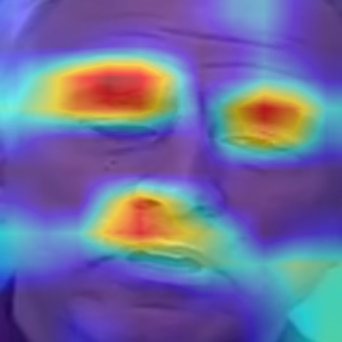

In [25]:
# target 정의, load한 이미지(금붕어)의 label이 22라서 22 입력
targets = [ClassifierOutputTarget(0)]

# cam 생성 및 처리
cam = GradCAM(model=model, target_layers=[layer])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
display(Image.fromarray(visualization))